In [1]:
import numpy as np
from astropy import units as u

from scipy.interpolate import griddata
import tesswcs
from tesswcs import pointings
from tesswcs.utils import footprint

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, Angle

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation, PillowWriter

mpl.rcParams['figure.dpi'] = 150

In [2]:
ecliptic_plane = SkyCoord(np.arange(0, 360, 1), np.arange(0, 360, 1)*0, unit='deg', frame='geocentricmeanecliptic').transform_to('icrs')

In [ ]:
url = './backdrop.fits'#'http://galaxy.phy.cmich.edu/~axel/mwpan2/mwpan2_RGB_3600.fits'
hdu = fits.open(url, cache=True)[0]
wcs = WCS(hdu.header).dropaxis(-1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# add the image

R, C = np.meshgrid(np.arange(wcs.pixel_shape[1]), np.arange(wcs.pixel_shape[0]), indexing='ij')
c = wcs.pixel_to_world(C, R)
flux_data = hdu.data.sum(axis=0)
im = plt.pcolormesh(np.nan_to_num(c.l.wrap_at(180*u.deg).deg), np.nan_to_num(c.b.deg), flux_data, vmin=0, vmax=1000, cmap='Greys_r', zorder=-10, shading='nearest')
ax.set(xlabel='Galactic Longitude ($b$) [degrees]', ylabel='Galactic Latitude ($l$) [degrees]')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red

def get_points(sector=1):
    pointing = np.asarray(pointings[pointings['Sector'] == sector][['RA', "Dec", "Roll"]])[0]
    x, y, camera_indices = [], [], []
    for camera in np.arange(1, 5):
        camera_x, camera_y = [], []
        for ccd in np.arange(1, 5):
            wcs = tesswcs.WCS.predict(*pointing, camera=camera, ccd=ccd)
            c = wcs.pixel_to_world(*footprint(npoints=100).T).transform_to('galactic')
            camera_x.append(c.l.wrap_at(180*u.deg).deg)
            camera_y.append(c.b.deg)
        x.append(np.hstack(camera_x))
        y.append(np.hstack(camera_y))
        camera_indices.append(np.full(len(np.hstack(camera_x)), camera-1))
    return np.hstack(x), np.hstack(y), np.hstack(camera_indices)

# Initialize the scatter plot
# Create a custom colormap
custom_cmap = mcolors.ListedColormap(colors)

# Initialize the scatter plot with the custom colormap
scatter = ax.scatter([], [], c=[], s=0.1, cmap=custom_cmap, vmin=0, vmax=3)

legend_elements = [Line2D([0], [0], color=colors[i], lw=2, label=f"Camera {i+1}") for i in range(4)]
ax.legend(handles=legend_elements)

def update(sector):
    x, y, cameras = get_points(sector=sector)
    scatter.set_offsets(np.column_stack([x, y]))
    scatter.set_array(cameras)
    ax.set_title(f'TESS Sector {sector}')
    plt.savefig(f'tess_galactic_sector_{sector:03d}.png')

ani = FuncAnimation(fig, update, frames=np.arange(96, 97), repeat=False)
writer = PillowWriter(fps=1)
ani.save("tess_sectors_galactic_coordinates.gif", writer=writer)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/vp/0cx6k2252h3crd9y1sbmb3t8pt0891/T/ipykernel_26758/2375711252.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'tess_galactic_sector_{sector:03d}.png')


In [4]:
# Interpolate image to ICRS
c_back = wcs.pixel_to_world(C, R).transform_to('icrs')
# xi, yi = np.linspace(-180, 180, 3000), np.linspace(-90, 90, 1500)
xi, yi = np.linspace(-180, 180, 300), np.linspace(-90, 90, 150)
zi = np.asarray(griddata((np.nan_to_num(c_back.ra.wrap_at(180*u.deg).deg.flatten()),
                          np.nan_to_num(c_back.dec.deg.flatten())),
                          flux_data.flatten(),
                          (xi[None,:], yi[:,None])
                         ))
c_low = SkyCoord(*np.meshgrid(xi, yi), unit='deg', frame='icrs')

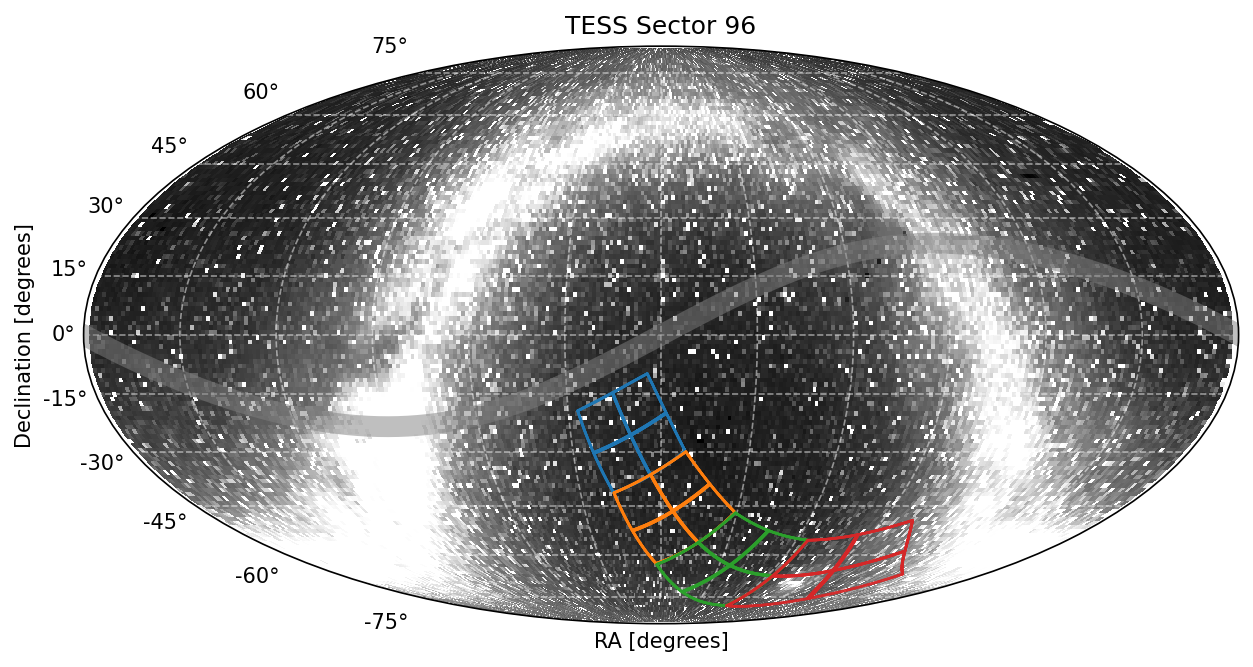

In [5]:
# Define explicit colors that match the default color cycle
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red

fig = plt.figure(figsize=(10, 5), facecolor=None)
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True, color='white', alpha=0.5, ls='--')
ax.pcolormesh(c_low.ra[2:-2, 2:-2].wrap_at(180*u.deg).rad, c_low.dec[2:-2, 2:-2].rad, zi[2:-2, 2:-2], vmin=0, vmax=1000, cmap='Greys_r')
s = np.argsort(ecliptic_plane.ra.wrap_at(180 * u.deg).rad)
ax.plot(ecliptic_plane.ra.wrap_at(180 * u.deg).rad[s], ecliptic_plane.dec.rad[s], color='grey', alpha=0.5, lw=10)
ax.set(facecolor=(0, 0, 0, 0), xlabel='RA [degrees]', ylabel='Declination [degrees]', xticklabels=[])

def get_points(sector=1):
    pointing = np.asarray(pointings[pointings['Sector'] == sector][['RA', "Dec", "Roll"]])[0]
    x, y, camera_indices = [], [], []
    for camera in np.arange(1, 5):
        for ccd in np.arange(1, 5):
            wcs = tesswcs.WCS.predict(*pointing, camera=camera, ccd=ccd)
            c = wcs.pixel_to_world(*footprint(npoints=100).T)
            x.append(c.ra.wrap_at(180*u.deg).rad)
            y.append(c.dec.rad)
            camera_indices.append(np.full(c.shape[0], camera-1))
    return np.hstack(x), np.hstack(y), np.hstack(camera_indices)

# Create a custom colormap
custom_cmap = mcolors.ListedColormap(colors)

# Initialize the scatter plot with the custom colormap
scatter = ax.scatter([], [], c=[], s=0.1, cmap=custom_cmap, vmin=0, vmax=3, zorder=10)

def update(sector):
    x, y, camera_indices = get_points(sector=sector)
    scatter.set_offsets(np.column_stack([x, y]))
    scatter.set_array(camera_indices)
    ax.set_title(f'TESS Sector {sector}')
    plt.savefig(f'tess_icrs_sector_{sector:03d}.png')
    return scatter,

ani = FuncAnimation(fig, update, frames=np.arange(96, 97), blit=True, repeat=False)

# Save the animation as a GIF
writer = PillowWriter(fps=1)
ani.save("tess_sectors_icrs_coordinates.gif", writer=writer)